# ch8 回归-预测数值型数据

回归，即对连续型的数据做出预测。

数据集X和标签集Y，求出回归方程就是求出使得y=x^T*w的w，常用方法就是找出使误差最小的w。
> 这里的误差是指预测值y与真实值y之间的差值，为了避免正负误差值相互抵消,采用平方误差.

平方误差公式
$$
\sum_{i=1}^{m}(y_i-x_{i}^{T}w)^2
$$

写成矩阵形式就是:
$$
(y-Xw)^T(y-Xw)
$$

## 普通最小二乘法

对w求导,并令为0,可以求出w,即:
$$
X^T(Y-Xw)=0
$$
解出w为
$$
\hat{w}=(X^T X)^{-1}X^Ty
$$
> $\hat{w}$是w的估计值.

这种求解w的方法,也叫做普通最小二乘法.

代码如下.

In [1]:
import numpy as np

In [2]:
def loadDataSet(fileName):      
    # 数据集特征数
    featureNum = len(open(fileName).readline().split('\t')) - 1 
    # 数据集,标签集
    dataArr = []; labelArr = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr =[]
        curLine = line.strip().split('\t')
        for i in range(featureNum):
            lineArr.append(float(curLine[i]))
        dataArr.append(lineArr)
        # 最后一列是label列
        labelArr.append(float(curLine[-1]))
    return dataArr,labelArr

assert(type(a)==list)

In [3]:
def standRegres(xArr,yArr):
    # 返回回归系数矩阵w
    # 转为矩阵
    X = np.mat(xArr); Y = np.mat(yArr).T
    
    # Y,m*1
    assert(Y.shape==(Y.shape[0],1))
    
    xTx = X.T*X
    # np.linalg为范数运算
    # np.linalg.det(X)表示计算矩阵X的行列式
    if np.linalg.det(xTx) == 0.0:
        # 说明不可逆,报错并返回
        print("This matrix cannot do inverse")
        # 求伪逆
        xTx_I=np.linalg.pinv(xTx)
    else:
        xTx_I=xTx.I
    w = xTx_I * (X.T*Y)
    return w

In [4]:
# test
xArr,yArr=loadDataSet("./ex0.txt")
w=standRegres(xArr,yArr)
w

matrix([[3.00774324],
        [1.69532264]])

求出回归系数矩阵w之后,给定x,则
$\hat{y}=w[0]+w[1]*x1$


In [5]:
# 转为矩阵
# 使用np.array与np.mat转换结果相同
# 但后者无法直接使用plt.scatter(x,y)
x=np.array(xArr)[:,1]
y=np.array(yArr).T
y_hat=np.array(xArr)*w

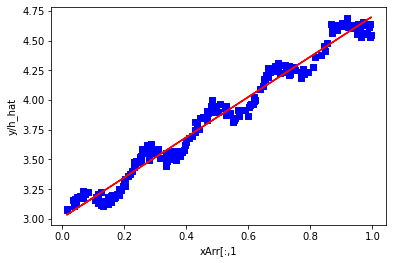

In [6]:
import matplotlib.pyplot  as plt

x=np.array(x)
y=np.array(y)

plt.figure()
plt.scatter(x,y,color='b',marker='s')
plt.plot(x,y_hat,c='r',label='regres')

plt.xlabel("xArr[:,1")
plt.ylabel("y/h_hat")
plt.show()

使用np.corrcoef(xArr,yArr)计算相关性.

In [7]:
print(x.shape)
print(y.shape)
print(y_hat.shape)

(200,)
(200,)
(200, 1)


In [8]:
# 确保两个参数都是行向量
np.corrcoef(y.T,y_hat.T)

array([[1.        , 0.98647356],
       [0.98647356, 1.        ]])

## 8-2 局部加权线性回归算法(locally weighted linear regression,LWLR)

在该算法中,给预测点附近的每个点给予一定的权重,然后在这个子集上基于最小均方差进行回归.

这种算法每次需要选择子集,回归系数求解公式如下

$$
\hat{w}=(X^T WX)^{-1}X^TWy
$$
>其中,w是权重矩阵

关于权重,常用是高斯核给附近数据点赋予权重,公式如下
$$
w(i,i)=exp\{ \frac{|x^{(i)}-x|}{-2k^2} \}
$$
>点x距离x(i)越近,w(i,i)越大,k是由用户指定的.

对应代码

In [9]:
def lwlr(testPoint,xArr,yArr,k=1.0):
    xMat = np.mat(xArr); yMat = np.mat(yArr).T
    m = np.shape(xMat)[0]
    # 单位矩阵,方阵
    weights = np.mat(np.eye((m))) 
    for j in range(m):                      #next 2 lines create weights matrix
        diffMat = testPoint - xMat[j,:]     #
        weights[j,j] = np.exp(diffMat*diffMat.T/(-2.0*k**2))
    xTx = xMat.T * (weights * xMat)
    if np.linalg.det(xTx) == 0.0:
        print("This matrix is singular, cannot do inverse")
        return
    ws = xTx.I * (xMat.T * (weights * yMat))
    return testPoint * ws

In [10]:
# test
lwlr(xArr[0],xArr,yArr,1.0)

matrix([[3.12204471]])

In [11]:
def lwlrTest(testArr,xArr,yArr,k=1.0):  
    #loops over all the data points and applies lwlr to each one
    m = np.shape(testArr)[0]
    yHat = np.zeros(m)
    for i in range(m):
        yHat[i] = lwlr(testArr[i],xArr,yArr,k)
    return yHat

In [12]:
xArr,yArr=loadDataSet("./ex0.txt")
y_hat=lwlrTest(xArr,xArr,yArr,0.003)

In [13]:
print(x.shape)
print(y.shape)
print(y_hat.shape)

(200,)
(200,)
(200,)


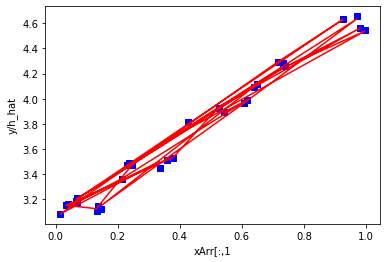

In [14]:
import matplotlib.pyplot  as plt

x=np.array(x)
y=np.array(y)

plt.figure()
plt.scatter(x[:30],y[:30],color='b',marker='s')
plt.plot(x[:30],y_hat[:30],c='r',label='regres')

plt.xlabel("xArr[:,1")
plt.ylabel("y/h_hat")
plt.show()

## 8-4 缩减系数 -岭回归

如果数据的特征比样本数多，$(X^TX)^{-1}$就会出错，所以就不能用前面的方法了。

为了解决这个问题，引入了“岭回归”，就是在$X^T$上加一个$\lambda I$，使得$X^t X+\lambda I$
可以求逆。

于是，回归系数计算公式变为：
$$
\hat{w}=(X^T X + \lambda I)^{-1} X^T y
$$

通过引入$\lambda$限制所有的w之和，减少不必要的参数。这种方法也叫做“缩减”。



In [15]:
def ridgeRegres(xMat,yMat,lam=0.2):
    # 给定lambda下，岭回归求解
    xTx = xMat.T*xMat
    denom = xTx + np.eye(np.shape(xMat)[1])*lam
    if np.linalg.det(denom) == 0.0:
        print("This matrix is singular, cannot do inverse")
        return
    w = denom.I * (xMat.T*yMat)
    return w

In [16]:
def ridgeTest(xArr,yArr):
    xMat = np.mat(xArr); yMat=np.mat(yArr).T
    yMean = np.mean(yMat,0)
    yMat = yMat - yMean     
    #to eliminate X0 take mean off of Y
    #regularize X's
    # 标准化处理
    xMeans = np.mean(xMat,0)   
    #calc mean then subtract it off
    xVar = np.var(xMat,0)      
    #calc variance of Xi then divide by it
    xMat = (xMat - xMeans)/xVar
    numTestPts = 30
    wMat = np.zeros((numTestPts,np.shape(xMat)[1]))
    for i in range(numTestPts):
        ws = ridgeRegres(xMat,yMat,np.exp(i-10))
        wMat[i,:]=ws.T
    return wMat

In [17]:
# test
x,y=loadDataSet('./abalone.txt')
weights=ridgeTest(x,y)
weights.shape

(30, 8)

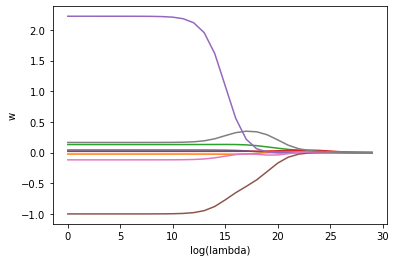

In [18]:
plt.figure()
plt.plot(weights)
plt.xlabel('log(lambda)')
plt.ylabel('w')
plt.show()

## 缩减方法2-lasso

在普通二乘法的基础上，增加如下约束条件：
$$
\sum_{k=1}^{n}w_{k}^{2}\leq \lambda
$$
>限定了回归系数的平方和不能大于lambda
则得岭回归公式。

如果使用以下约束条件：
$$
\sum_{k=1}^{n}|w_{k}| \leq k
$$
则得到另一个缩减方法lasso

两者的不同点是在后者的约束条件使用绝对值代替了平方和。

## 缩减方法3-前向逐步回归

这是一种贪心算法，每一步都尽可能的减少误差。

一开始，所有权重都为1，然后每一步就是对某个权重增加或减少一个很小的值。

伪代码：
```
数据标准化
开始迭代：
    设置最小误差=inf
    对于每个特征：
        增大或减少：
            改变一个系数得到新的w
            计算新w下的误差
            如果误差比最小误差小：
                更新最小误差为该值
                各位w为新的w
```


In [19]:
def regularize(xMat):
    # regularize by columns
    inMat = xMat.copy()
    inMeans = np.mean(inMat,0)   #calc mean then subtract it off
    inVar = np.var(inMat,0)      #calc variance of Xi then divide by it
    inMat = (inMat - inMeans)/inVar
    return inMat

In [20]:
def rssError(yArr,yHatArr): #yArr and yHatArr both need to be arrays
    return ((yArr-yHatArr)**2).sum()

In [21]:
def stageWise(xArr,yArr,eps=0.01,numIt=200):
    xMat = np.mat(xArr); yMat=np.mat(yArr).T
    yMean = np.mean(yMat,0)
    yMat = yMat - yMean     #can also regularize ys but will get smaller coef
    xMat = regularize(xMat)
    m,n=np.shape(xMat)
    returnMat = np.zeros((numIt,n)) #testing code remove
    ws = np.zeros((n,1)); wsTest = ws.copy(); wsMax = ws.copy()
    for i in range(numIt):
    # could change this to while loop
        #print ws.T
        lowestError = np.inf; 
        for j in range(n):
            for sign in [-1,1]:
                wsTest = ws.copy()
                wsTest[j] += eps*sign
                yTest = xMat*wsTest
                rssE = rssError(yMat.A,yTest.A)
                if rssE < lowestError:
                    lowestError = rssE
                    wsMax = wsTest
        ws = wsMax.copy()
        returnMat[i,:]=ws.T
    return returnMat

In [22]:
# test
x,y=loadDataSet('./abalone.txt')
w=stageWise(x,y)

In [23]:
print(len(w))
w[:2]

200


array([[0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.02, 0.  , 0.  , 0.  , 0.  ]])